# OTMapOnto
### Apply Optimal Transport on ontology embeddings for ontology mapping 

In [2]:
# import libraries
import pandas as pd
import numpy as np
import scipy as sp
import json

from rdflib import Graph, URIRef, RDFS
from gensim.models.fasttext import FastText
from gensim.models.fasttext import load_facebook_model
from gensim.models.fasttext import load_facebook_vectors

import corpus_build_utils
from corpus_build_utils import clean_document_lower
from AlignmentFormat import serialize_mapping_to_tmp_file

import sys
import logging
from collections import defaultdict

import jellyfish
import ot

from xml.dom import minidom
from nltk.corpus import wordnet

import importlib

import matplotlib.pyplot as plt
%matplotlib inline

import camelsplit

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("logging info test")

INFO:root:logging info test


In [4]:
import OTMapOnto as maponto

In [5]:
importlib.reload(maponto)
importlib.reload(corpus_build_utils)
from corpus_build_utils import clean_document_lower

# Simple Label Matcher

In [603]:
src_url = "../data/mouse.owl"
tgt_url = "../data/human.owl"
src_graph = Graph().parse(src_url)
tgt_graph = Graph().parse(tgt_url)

In [604]:
slabel_uris = maponto.extract_label_uris(src_graph)
slabel_uris.shape

(2737, 2)

In [605]:
slabel_uris.head()

,label,uri
0,mouse anatomy,http://mouse.owl#MA_0000001
1,spinal cord grey matter,http://mouse.owl#MA_0000002
2,organ system,http://mouse.owl#MA_0000003
3,trunk,http://mouse.owl#MA_0000004
4,body cavity/lining,http://mouse.owl#MA_0000005


In [606]:
tlabel_uris = maponto.extract_label_uris(tgt_graph)
tlabel_uris.shape

(3298, 2)

In [607]:
tlabel_uris.head()

,label,uri
0,Anatomic_Structure_System_or_Substance,http://human.owl#NCI_C12219
1,Lip,http://human.owl#NCI_C12220
2,External_Upper_Lip,http://human.owl#NCI_C12221
3,External_Lower_Lip,http://human.owl#NCI_C12222
4,External_Lip,http://human.owl#NCI_C12223


In [608]:
slabel_clnd_uris = maponto.clean_labels(slabel_uris)
slabel_clnd_uris.shape

(2737, 3)

In [609]:
slabel_clnd_uris.head()

,label,uri,clndLabel
0,mouse anatomy,http://mouse.owl#MA_0000001,mouse anatomy
1,spinal cord grey matter,http://mouse.owl#MA_0000002,spinal cord grey matter
2,organ system,http://mouse.owl#MA_0000003,organ system
3,trunk,http://mouse.owl#MA_0000004,trunk
4,body cavity/lining,http://mouse.owl#MA_0000005,body cavity lining


In [610]:
tlabel_clnd_uris = maponto.clean_labels(tlabel_uris)
tlabel_clnd_uris.shape

(3298, 3)

In [611]:
tlabel_clnd_uris.head()

,label,uri,clndLabel
0,Anatomic_Structure_System_or_Substance,http://human.owl#NCI_C12219,anatomic structure system substance
1,Lip,http://human.owl#NCI_C12220,lip
2,External_Upper_Lip,http://human.owl#NCI_C12221,external upper lip
3,External_Lower_Lip,http://human.owl#NCI_C12222,external lower lip
4,External_Lip,http://human.owl#NCI_C12223,external lip


In [612]:
match_labels_df = maponto.match_concept_labels(slabel_clnd_uris, tlabel_clnd_uris, None)
match_labels_df.shape

(951, 4)

In [613]:
match_labels_df.head()

,source,source_label,target,target_label
0,http://mouse.owl#MA_0000003,organ system,http://human.owl#NCI_C12919,Organ_System
1,http://mouse.owl#MA_0000004,trunk,http://human.owl#NCI_C33816,Trunk
2,http://mouse.owl#MA_0000006,head/neck,http://human.owl#NCI_C12418,Head_and_Neck
3,http://mouse.owl#MA_0000007,limb,http://human.owl#NCI_C12429,Limb
4,http://mouse.owl#MA_0000009,adipose tissue,http://human.owl#NCI_C12472,Adipose_Tissue


In [614]:
# Check duplicated labels
match_labels_df[match_labels_df.source.isin(['http://mouse.owl#MA_0001388', 'http://mouse.owl#MA_0001395'])]

,source,source_label,target,target_label
428,http://mouse.owl#MA_0001388,distal phalanx of hand,http://human.owl#NCI_C12864,Distal_Phalanx_of_the_Hand
429,http://mouse.owl#MA_0001388,distal phalanx of hand,http://human.owl#NCI_C52784,Distal_Phalanx_of_Hand
436,http://mouse.owl#MA_0001395,proximal phalanx of hand,http://human.owl#NCI_C12862,Proximal_Phalanx_of_the_Hand
437,http://mouse.owl#MA_0001395,proximal phalanx of hand,http://human.owl#NCI_C52786,Proximal_Phalanx_of_Hand


# Embedding Concept Labels and Applying OT

In [615]:
slabel_clnd_uris_sub = slabel_clnd_uris[slabel_clnd_uris.uri.isin(match_labels_df.source)==False].reset_index(drop=True)
tlabel_clnd_uris_sub = tlabel_clnd_uris[tlabel_clnd_uris.uri.isin(match_labels_df.target)==False].reset_index(drop=True)

In [616]:
%%time
model_path="../data/crawl-300d-2M-subword.bin"
embs_model = maponto.load_embeddings(model_path, embs_model)

INFO:root:Load pre-trained embeddings


CPU times: user 1.19 ms, sys: 946 µs, total: 2.13 ms
Wall time: 1.25 ms


In [617]:
'abdomen' in embs_model

True

In [618]:
slabel_clnd_uris_sub.columns

Index(['label', 'uri', 'clndLabel'], dtype='object')

In [619]:
costs = maponto.costs_embeddings(slabel_clnd_uris_sub.clndLabel.tolist(), tlabel_clnd_uris_sub.clndLabel.tolist(), embs_model)

INFO:root:Computing the Ground Costs between the Source and Target Points...


In [620]:
costs.max(), costs.min(), costs.shape

(1.0, 0.0, (1788, 2347))

In [621]:
(costs == 0).sum()

15

In [622]:
# Compute the mutual NN
ts = costs.shape[0]
best_match_src = costs.argmin(1)
best_match_trg = costs.argmin(0)
mut_nn = []
for i in range(ts):
    try:
        m = best_match_src[i]
        if best_match_trg[m] == i: 
            mut_nn.append((i, m))
    except IndexError:
        print('Encountered index error')
        print(self.ns)
        pass
len(mut_nn)

453

In [623]:
couplings = maponto.ot_couplings(slabel_clnd_uris_sub.shape[0], tlabel_clnd_uris_sub.shape[0], costs)

INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...


In [624]:
couplings.shape

(1788, 2347)

In [625]:
couplings.max(), couplings.min()

(0.0004847104303064713, 0.0)

In [626]:
ot_alignments = maponto.match_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model, maponto.make_mappings_nn, None, None)

INFO:root:Matching Embeddings by Optimal Transport...
INFO:root:Computing the Ground Costs between the Source and Target Points...
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...


In [627]:
ot_alignments.shape

(937, 4)

In [628]:
ot_alignments.sample(10)

,source,source_label,target,target_label
755,http://mouse.owl#MA_0002217,small saphenous vein,http://human.owl#NCI_C12881,Small_Cardiac_Vein
742,http://mouse.owl#MA_0002163,left hepatico-cardiac vein,http://human.owl#NCI_C32958,Left_Coronary_Artery_Branch
211,http://mouse.owl#MA_0000580,head nerve/ganglion,http://human.owl#NCI_C13155,Ganglion_Cell
167,http://mouse.owl#MA_0000479,right dorsal aorta,http://human.owl#NCI_C33474,Right_Common_Iliac_Artery
520,http://mouse.owl#MA_0001482,viscerocranium bone,http://human.owl#NCI_C12857,Trapezial_Bone
444,http://mouse.owl#MA_0001257,inferior eyelid tarsus,http://human.owl#NCI_C32785,Inferior_Palpebral_Fold
42,http://mouse.owl#MA_0000105,cellular cartilage,http://human.owl#NCI_C48695,Cartilage_Cell
649,http://mouse.owl#MA_0001804,respiratory system artery,http://human.owl#NCI_C33427,Pulmonary_Artery_Branch
710,http://mouse.owl#MA_0002016,pericardiacoophrenic artery,http://human.owl#NCI_C33295,Pericallosal_Artery
201,http://mouse.owl#MA_0000561,thorax muscle,http://human.owl#NCI_C33145,Muscle_and_Fasciae_of_the_Thorax


# Visualize the Costs and OT Plan

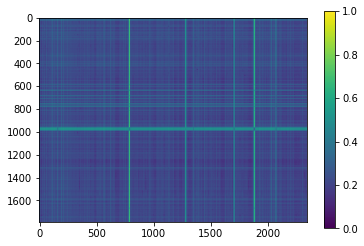

In [629]:
plt.imshow(costs)
plt.colorbar()

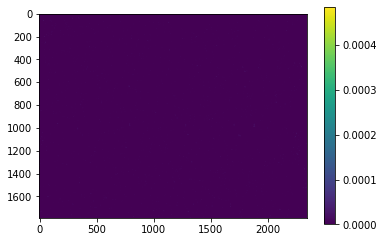

In [630]:
plt.imshow(couplings)
plt.colorbar()

In [631]:
costs.shape

(1788, 2347)

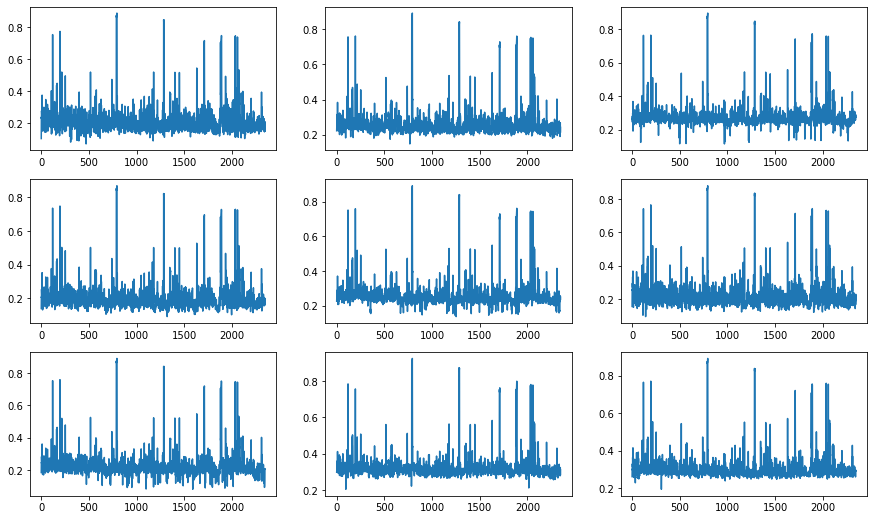

In [632]:
fig, axs = plt.subplots(3, 3, figsize=(15, 9))
axs[0,0].plot(costs[4])
axs[0,1].plot(costs[403])
axs[0,2].plot(costs[1094])
axs[1,0].plot(costs[564])
axs[1,1].plot(costs[1403])
axs[1,2].plot(costs[94])
axs[2,0].plot(costs[1564])
axs[2,1].plot(costs[31])
axs[2,2].plot(costs[948])

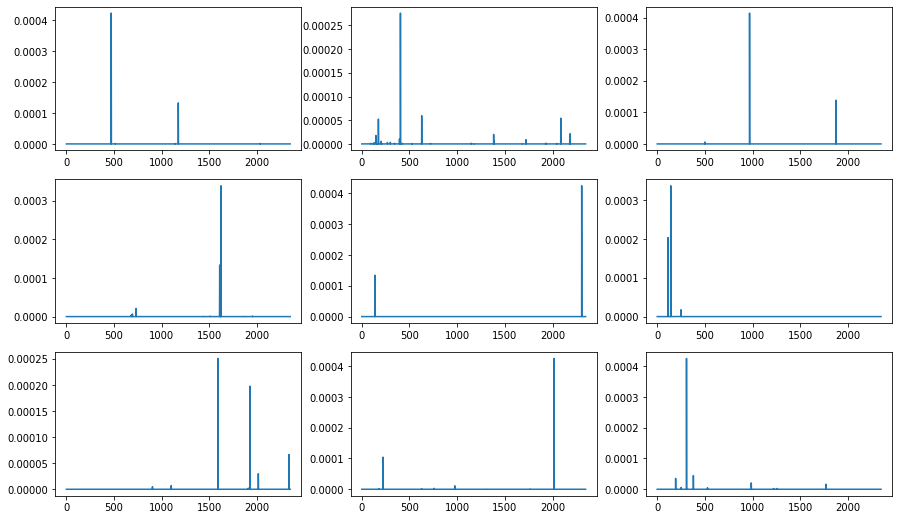

In [633]:
fig, axs = plt.subplots(3, 3, figsize=(15, 9))
axs[0,0].plot(couplings[4])
axs[0,1].plot(couplings[403])
axs[0,2].plot(couplings[1094])
axs[1,0].plot(couplings[564])
axs[1,1].plot(couplings[1403])
axs[1,2].plot(couplings[94])
axs[2,0].plot(couplings[1564])
axs[2,1].plot(couplings[31])
axs[2,2].plot(couplings[948])

In [635]:
(couplings != 0).sum()

4163740

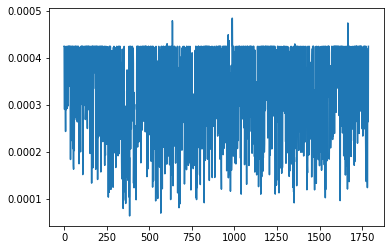

In [636]:
plt.plot(couplings.max(1))

In [642]:
couplings.max()

0.0004847104303064713

In [643]:
(couplings.max(1) > (couplings.max(1).mean())).sum()

937

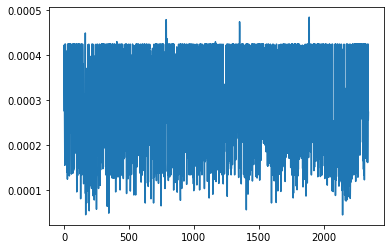

In [644]:
plt.plot(couplings.max(0))

In [640]:
couplings_perc = couplings / couplings.sum(1).reshape(-1, 1)

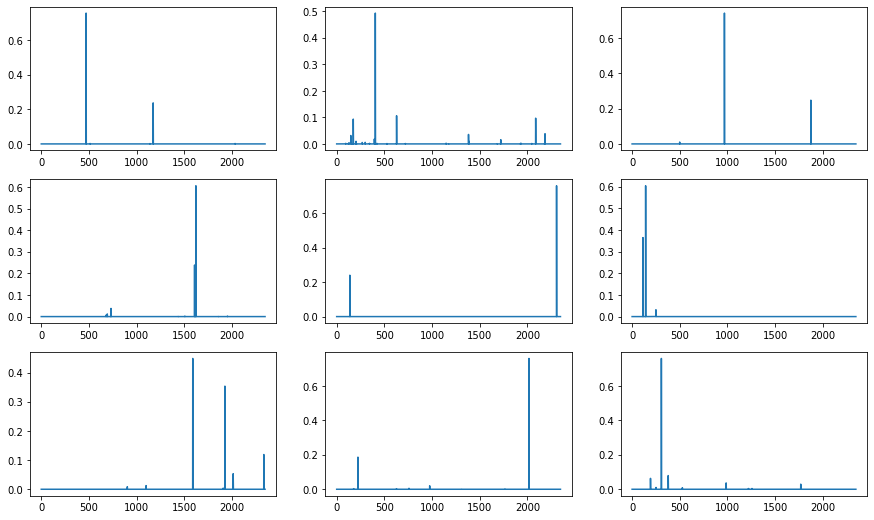

In [641]:
fig, axs = plt.subplots(3, 3, figsize=(15, 9))
axs[0,0].plot(couplings_perc[4])
axs[0,1].plot(couplings_perc[403])
axs[0,2].plot(couplings_perc[1094])
axs[1,0].plot(couplings_perc[564])
axs[1,1].plot(couplings_perc[1403])
axs[1,2].plot(couplings_perc[94])
axs[2,0].plot(couplings_perc[1564])
axs[2,1].plot(couplings_perc[31])
axs[2,2].plot(couplings_perc[948])

# Load the References DataFrame for Evaluation

In [645]:
refs_df = pd.read_csv("../data/reference_mappings.csv")
refs_df.shape

(1516, 6)

In [646]:
refs_df.head()

,entity1,entity1_label,entity2,entity2_label,relation,measure
0,http://mouse.owl#MA_0000029,abdomen,http://human.owl#NCI_C12664,Abdominal_Cavity,=,1
1,http://mouse.owl#MA_0000520,abdomen muscle,http://human.owl#NCI_C32040,Abdominal_Muscle,=,1
2,http://mouse.owl#MA_0000523,abdomen skin,http://human.owl#NCI_C52758,Abdominal_Skin,=,1
3,http://mouse.owl#MA_0000474,abdominal aorta,http://human.owl#NCI_C32038,Abdominal_Aorta,=,1
4,http://mouse.owl#MA_0001087,abducens VI nerve,http://human.owl#NCI_C12665,Abducens_Nerve,=,1


In [647]:
ot_alignments.merge(refs_df, left_on=['source', 'target'], right_on=['entity1', 'entity2'], how='inner')

,source,source_label,target,target_label,entity1,entity1_label,entity2,entity2_label,relation,measure
0,http://mouse.owl#MA_0000002,spinal cord grey matter,http://human.owl#NCI_C32696,Gray_Matter_of_the_Spinal_Cord,http://mouse.owl#MA_0000002,spinal cord grey matter,http://human.owl#NCI_C32696,Gray_Matter_of_the_Spinal_Cord,=,1
1,http://mouse.owl#MA_0000014,integumental system,http://human.owl#NCI_C12907,Integumentary_System,http://mouse.owl#MA_0000014,integumental system,http://human.owl#NCI_C12907,Integumentary_System,=,1
2,http://mouse.owl#MA_0000052,upper leg,http://human.owl#NCI_C33763,Thigh,http://mouse.owl#MA_0000052,upper leg,http://human.owl#NCI_C33763,Thigh,=,1
3,http://mouse.owl#MA_0000057,brown fat,http://human.owl#NCI_C32235,Brown_Adipose_Tissue,http://mouse.owl#MA_0000057,brown fat,http://human.owl#NCI_C32235,Brown_Adipose_Tissue,=,1
4,http://mouse.owl#MA_0000074,heart left atrium,http://human.owl#NCI_C12869,Left_Atrium,http://mouse.owl#MA_0000074,heart left atrium,http://human.owl#NCI_C12869,Left_Atrium,=,1
...,...,...,...,...,...,...,...,...,...,...
259,http://mouse.owl#MA_0002696,small intestine wall,http://human.owl#NCI_C33573,Small_Intestinal_Wall_Tissue,http://mouse.owl#MA_0002696,small intestine wall,http://human.owl#NCI_C33573,Small_Intestinal_Wall_Tissue,=,1
260,http://mouse.owl#MA_0002700,anterior buccal gland,http://human.owl#NCI_C32237,Buccal_Salivary_Gland,http://mouse.owl#MA_0002700,anterior buccal gland,http://human.owl#NCI_C32237,Buccal_Salivary_Gland,=,1
261,http://mouse.owl#MA_0002701,anterior lingual gland,http://human.owl#NCI_C32987,Lingual_Salivary_Gland,http://mouse.owl#MA_0002701,anterior lingual gland,http://human.owl#NCI_C32987,Lingual_Salivary_Gland,=,1
262,http://mouse.owl#MA_0002734,endometrium stroma,http://human.owl#NCI_C32516,Endometrial_Stroma,http://mouse.owl#MA_0002734,endometrium stroma,http://human.owl#NCI_C32516,Endometrial_Stroma,=,1


In [648]:
match_labels_df.merge(refs_df, left_on=['source', 'target'], right_on=['entity1', 'entity2'], how='inner')

,source,source_label,target,target_label,entity1,entity1_label,entity2,entity2_label,relation,measure
0,http://mouse.owl#MA_0000004,trunk,http://human.owl#NCI_C33816,Trunk,http://mouse.owl#MA_0000004,trunk,http://human.owl#NCI_C33816,Trunk,=,1
1,http://mouse.owl#MA_0000006,head/neck,http://human.owl#NCI_C12418,Head_and_Neck,http://mouse.owl#MA_0000006,head/neck,http://human.owl#NCI_C12418,Head_and_Neck,=,1
2,http://mouse.owl#MA_0000007,limb,http://human.owl#NCI_C12429,Limb,http://mouse.owl#MA_0000007,limb,http://human.owl#NCI_C12429,Limb,=,1
3,http://mouse.owl#MA_0000009,adipose tissue,http://human.owl#NCI_C12472,Adipose_Tissue,http://mouse.owl#MA_0000009,adipose tissue,http://human.owl#NCI_C12472,Adipose_Tissue,=,1
4,http://mouse.owl#MA_0000010,cardiovascular system,http://human.owl#NCI_C12686,Cardiovascular_System,http://mouse.owl#MA_0000010,cardiovascular system,http://human.owl#NCI_C12686,Cardiovascular_System,=,1
...,...,...,...,...,...,...,...,...,...,...
943,http://mouse.owl#MA_0002722,anterior commissure,http://human.owl#NCI_C32086,Anterior_Commissure,http://mouse.owl#MA_0002722,anterior commissure,http://human.owl#NCI_C32086,Anterior_Commissure,=,1
944,http://mouse.owl#MA_0002726,glans penis,http://human.owl#NCI_C12324,Glans_Penis,http://mouse.owl#MA_0002726,glans penis,http://human.owl#NCI_C12324,Glans_Penis,=,1
945,http://mouse.owl#MA_0002730,renal papilla,http://human.owl#NCI_C33460,Renal_Papilla,http://mouse.owl#MA_0002730,renal papilla,http://human.owl#NCI_C33460,Renal_Papilla,=,1
946,http://mouse.owl#MA_0002743,posterior commissure,http://human.owl#NCI_C33356,Posterior_Commissure,http://mouse.owl#MA_0002743,posterior commissure,http://human.owl#NCI_C33356,Posterior_Commissure,=,1


In [649]:
refs_df.merge(ot_alignments, left_on=['entity1'], right_on=['source'], how='inner')

,entity1,entity1_label,entity2,entity2_label,relation,measure,source,source_label,target,target_label
0,http://mouse.owl#MA_0000520,abdomen muscle,http://human.owl#NCI_C32040,Abdominal_Muscle,=,1,http://mouse.owl#MA_0000520,abdomen muscle,http://human.owl#NCI_C32040,Abdominal_Muscle
1,http://mouse.owl#MA_0000523,abdomen skin,http://human.owl#NCI_C52758,Abdominal_Skin,=,1,http://mouse.owl#MA_0000523,abdomen skin,http://human.owl#NCI_C52758,Abdominal_Skin
2,http://mouse.owl#MA_0001010,abducens VI nucleus,http://human.owl#NCI_C12836,Abducens_Nucleus,=,1,http://mouse.owl#MA_0001010,abducens VI nucleus,http://human.owl#NCI_C16753,Gated_Ion_Channel
3,http://mouse.owl#MA_0000177,adenohypophysis,http://human.owl#NCI_C12772,Anterior_Lobe_of_the_Pituitary_Gland,=,1,http://mouse.owl#MA_0000177,adenohypophysis,http://human.owl#NCI_C13015,Myeloblast
4,http://mouse.owl#MA_0000118,adrenal gland cortex,http://human.owl#NCI_C12396,Adrenal_Cortex,=,1,http://mouse.owl#MA_0000118,adrenal gland cortex,http://human.owl#NCI_C12396,Adrenal_Cortex
...,...,...,...,...,...,...,...,...,...,...
396,http://mouse.owl#MA_0000019,visceral organ system,http://human.owl#NCI_C28287,Viscera,=,1,http://mouse.owl#MA_0000019,visceral organ system,http://human.owl#NCI_C13058,Special_Sense_Organ_System
397,http://mouse.owl#MA_0001496,vomer bone,http://human.owl#NCI_C33888,Vomer,=,1,http://mouse.owl#MA_0001496,vomer bone,http://human.owl#NCI_C33888,Vomer
398,http://mouse.owl#MA_0000058,white fat,http://human.owl#NCI_C33889,White_Adipose_Tissue,=,1,http://mouse.owl#MA_0000058,white fat,http://human.owl#NCI_C33891,White_Fiber
399,http://mouse.owl#MA_0001334,xiphisternum,http://human.owl#NCI_C33895,Xiphoid_Process,=,1,http://mouse.owl#MA_0001334,xiphisternum,http://human.owl#NCI_C32741,Epencephalon


In [650]:
'zygomatic' in embs_model

True

# Use WordNet for Labels

In [43]:
labtest1 = "abdomen"
labtest2 = 'abdominal cavity'

In [44]:
maponto.normalize_nounsyn_counts(labtest1)

defaultdict(int,
            {'abdomen': 3,
             'venter': 1,
             'stomach': 1,
             'belly': 1,
             'abdominal cavity': 1})

In [45]:
maponto.normalize_nounsyn_counts(labtest2)

defaultdict(int, {'abdominal cavity': 1})

# Check if WordNet Makes Labels Match

In [46]:
importlib.reload(maponto)

<module 'OTMapOnto' from '/Users/yan/Google Drive/ontology-mapping/src/OTMapOnto.py'>

In [48]:
synset_alignments = maponto.match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, None)
synset_alignments.shape

INFO:root:Retrieving Synsets by WordNet...


(32, 4)

In [49]:
# How many wordnet-based matchings are correct alignments?
synset_alignments.merge(refs_df, left_on=['source', 'target'], right_on=['entity1', 'entity2'], how='inner')

,source,source_label,target,target_label,entity1,entity1_label,entity2,entity2_label,relation,measure
0,http://mouse.owl#MA_0000029,abdomen,http://human.owl#NCI_C12664,Abdominal_Cavity,http://mouse.owl#MA_0000029,abdomen,http://human.owl#NCI_C12664,Abdominal_Cavity,=,1
1,http://mouse.owl#MA_0000114,synovium,http://human.owl#NCI_C12473,Synovial_Membrane,http://mouse.owl#MA_0000114,synovium,http://human.owl#NCI_C12473,Synovial_Membrane,=,1
2,http://mouse.owl#MA_0000142,thymus,http://human.owl#NCI_C12433,Thymus_Gland,http://mouse.owl#MA_0000142,thymus,http://human.owl#NCI_C12433,Thymus_Gland,=,1
3,http://mouse.owl#MA_0000169,brainstem,http://human.owl#NCI_C12441,Brain_Stem,http://mouse.owl#MA_0000169,brainstem,http://human.owl#NCI_C12441,Brain_Stem,=,1
4,http://mouse.owl#MA_0000170,forebrain,http://human.owl#NCI_C12455,Prosencephalon,http://mouse.owl#MA_0000170,forebrain,http://human.owl#NCI_C12455,Prosencephalon,=,1
5,http://mouse.owl#MA_0000185,cerebral cortex,http://human.owl#NCI_C12443,Cortex,http://mouse.owl#MA_0000185,cerebral cortex,http://human.owl#NCI_C12443,Cortex,=,1
6,http://mouse.owl#MA_0000204,pons,http://human.owl#NCI_C12511,Pons_Varolii,http://mouse.owl#MA_0000204,pons,http://human.owl#NCI_C12511,Pons_Varolii,=,1
7,http://mouse.owl#MA_0000207,midbrain,http://human.owl#NCI_C12510,Mesencephalon,http://mouse.owl#MA_0000207,midbrain,http://human.owl#NCI_C12510,Mesencephalon,=,1
8,http://mouse.owl#MA_0000275,lens,http://human.owl#NCI_C12743,Crystalline_Lens,http://mouse.owl#MA_0000275,lens,http://human.owl#NCI_C12743,Crystalline_Lens,=,1
9,http://mouse.owl#MA_0000322,synovial joint,http://human.owl#NCI_C32461,Diarthrosis,http://mouse.owl#MA_0000322,synovial joint,http://human.owl#NCI_C32461,Diarthrosis,=,1


In [50]:
# How many wordnet-based matchings overlap with ot_alignments?
synset_alignments.merge(ot_alignments, left_on=['source', 'target'], right_on=['source', 'target'], how='inner')

,source,source_label_x,target,target_label_x,source_label_y,target_label_y
0,http://mouse.owl#MA_0000142,thymus,http://human.owl#NCI_C12433,Thymus_Gland,thymus,Thymus_Gland
1,http://mouse.owl#MA_0000204,pons,http://human.owl#NCI_C12511,Pons_Varolii,pons,Pons_Varolii
2,http://mouse.owl#MA_0000275,lens,http://human.owl#NCI_C12743,Crystalline_Lens,lens,Crystalline_Lens
3,http://mouse.owl#MA_0000392,uterine cervix,http://human.owl#NCI_C12311,Cervix,uterine cervix,Cervix
4,http://mouse.owl#MA_0000891,striatum,http://human.owl#NCI_C12448,Corpus_Striatum,striatum,Corpus_Striatum
5,http://mouse.owl#MA_0001307,fovea,http://human.owl#NCI_C26463,Fovea_Centralis,fovea,Fovea_Centralis
6,http://mouse.owl#MA_0001343,hamate,http://human.owl#NCI_C12860,Hamate_Bone,hamate,Hamate_Bone
7,http://mouse.owl#MA_0001540,appendix,http://human.owl#NCI_C12380,Vermiform_Appendix,appendix,Vermiform_Appendix
8,http://mouse.owl#MA_0002306,gastrocnemius,http://human.owl#NCI_C32666,Gastrocnemius_Muscle,gastrocnemius,Gastrocnemius_Muscle
9,http://mouse.owl#MA_0002368,sartorius,http://human.owl#NCI_C33515,Sartorius_Muscle,sartorius,Sartorius_Muscle


In [51]:
# How many wordnet-based matchings are INCORRECT alignments, why?
synset_alignments.merge(refs_df, left_on=['source'], right_on=['entity1'], how='left')

,source,source_label,target,target_label,entity1,entity1_label,entity2,entity2_label,relation,measure
0,http://mouse.owl#MA_0000029,abdomen,http://human.owl#NCI_C12664,Abdominal_Cavity,http://mouse.owl#MA_0000029,abdomen,http://human.owl#NCI_C12664,Abdominal_Cavity,=,1.0
1,http://mouse.owl#MA_0000045,hip,http://human.owl#NCI_C33291,Pelvic_Girdle,NaN,NaN,NaN,NaN,NaN,NaN
2,http://mouse.owl#MA_0000114,synovium,http://human.owl#NCI_C12473,Synovial_Membrane,http://mouse.owl#MA_0000114,synovium,http://human.owl#NCI_C12473,Synovial_Membrane,=,1.0
3,http://mouse.owl#MA_0000142,thymus,http://human.owl#NCI_C12433,Thymus_Gland,http://mouse.owl#MA_0000142,thymus,http://human.owl#NCI_C12433,Thymus_Gland,=,1.0
4,http://mouse.owl#MA_0000163,vibrissa,http://human.owl#NCI_C32705,Hair,NaN,NaN,NaN,NaN,NaN,NaN
5,http://mouse.owl#MA_0000163,vibrissa,http://human.owl#NCI_C33531,Sensory_Hair,NaN,NaN,NaN,NaN,NaN,NaN
6,http://mouse.owl#MA_0000169,brainstem,http://human.owl#NCI_C12441,Brain_Stem,http://mouse.owl#MA_0000169,brainstem,http://human.owl#NCI_C12441,Brain_Stem,=,1.0
7,http://mouse.owl#MA_0000170,forebrain,http://human.owl#NCI_C12455,Prosencephalon,http://mouse.owl#MA_0000170,forebrain,http://human.owl#NCI_C12455,Prosencephalon,=,1.0
8,http://mouse.owl#MA_0000170,forebrain,http://human.owl#NCI_C12455,Prosencephalon,http://mouse.owl#MA_0000170,forebrain,http://human.owl#NCI_C40185,Fore-Brain,=,1.0
9,http://mouse.owl#MA_0000185,cerebral cortex,http://human.owl#NCI_C12443,Cortex,http://mouse.owl#MA_0000185,cerebral cortex,http://human.owl#NCI_C12443,Cortex,=,1.0


In [52]:
# Only get the first directl synonyms
for syn in wordnet.synsets('Pelvic_Girdle','n'):
    print(syn.lemma_names()[0])

pelvis


# Run OTMapOnto.match_test() in Notebook

In [109]:
refs_url = "../data/reference.rdf"

In [6]:
importlib.reload(maponto)

<module 'OTMapOnto' from '/Users/yan/Google Drive/ontology-mapping/src/OTMapOnto.py'>

In [776]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_nn, None, \
                                 'label', 'weighted', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...
INFO:root:The number of level_3 predicted matchings is 920


Total number of references is 1516
Total correctly predicted alignments is 1230
Total number of predicted is 1903
Precision is 0.6463478717813977
Recall is 0.8113456464379947
F1-Measure is 0.7195086282538753
CPU times: user 23.7 s, sys: 1.6 s, total: 25.3 s
Wall time: 11.4 s


In [777]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_nn, None, \
                                 'labelNeighbor', 'weighted', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Neighboring Word Embeddings by Optimal Transport...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Retrieving the words in the cleaned labels of the 1-hop neighbors...  
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...
INFO:root:The number of level_3 predicted matchings is 840


Total number of references is 1516
Total correctly predicted alignments is 1191
Total number of predicted is 1823
Precision is 0.6533187054306089
Recall is 0.7856200527704486
F1-Measure is 0.7133872416891285
CPU times: user 53.1 s, sys: 1.59 s, total: 54.7 s
Wall time: 41 s


In [778]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_nn, None, \
                                 'labelNeighbor', 'averaged', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Neighboring Word Embeddings by Optimal Transport...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Retrieving the words in the cleaned labels of the 1-hop neighbors...  
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...
INFO:root:The number of level_3 predicted matchings is 857


Total number of references is 1516
Total correctly predicted alignments is 1193
Total number of predicted is 1840
Precision is 0.6483695652173913
Recall is 0.7869393139841688
F1-Measure is 0.7109654350417163
CPU times: user 52.5 s, sys: 1.3 s, total: 53.8 s
Wall time: 41.3 s


In [779]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_nn, None, \
                                 'labelSyn', 'weighted', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Synonym Word Embeddings by Optimal Transport...
INFO:root:Retrieving the synonyms of the words in the cleaned labels... 
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...
INFO:root:The number of level_3 predicted matchings is 850


Total number of references is 1516
Total correctly predicted alignments is 1154
Total number of predicted is 1833
Precision is 0.629569012547736
Recall is 0.7612137203166227
F1-Measure is 0.6891609435652433
CPU times: user 29.4 s, sys: 1.47 s, total: 30.9 s
Wall time: 17.6 s


In [780]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_nn, None, \
                                 'labelSyn', 'averaged', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Synonym Word Embeddings by Optimal Transport...
INFO:root:Retrieving the synonyms of the words in the cleaned labels... 
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...
INFO:root:The number of level_3 predicted matchings is 909


Total number of references is 1516
Total correctly predicted alignments is 1170
Total number of predicted is 1892
Precision is 0.6183932346723044
Recall is 0.7717678100263852
F1-Measure is 0.6866197183098591
CPU times: user 28.4 s, sys: 1.34 s, total: 29.7 s
Wall time: 17 s


In [781]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_nn, None, \
                                 'labelNeighborSyn', 'weighted', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Neighboring Word and Synonym Embeddings by Optimal Transport...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Retrieving the words in the cleaned labels of the 1-hop neighbors and synonyms...  
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...
INFO:root:The number of level_3 predicted matchings is 880


Total number of references is 1516
Total correctly predicted alignments is 1162
Total number of predicted is 1863
Precision is 0.6237251744498121
Recall is 0.7664907651715039
F1-Measure is 0.6877774489493933
CPU times: user 57.6 s, sys: 1.51 s, total: 59.1 s
Wall time: 46 s


In [782]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_nn, None, \
                                 'labelNeighborSyn', 'averaged', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Neighboring Word and Synonym Embeddings by Optimal Transport...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Retrieving the words in the cleaned labels of the 1-hop neighbors and synonyms...  
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...
INFO:root:The number of level_3 predicted matchings is 858


Total number of references is 1516
Total correctly predicted alignments is 1164
Total number of predicted is 1841
Precision is 0.6322650733297122
Recall is 0.7678100263852242
F1-Measure is 0.6934763181411975
CPU times: user 59.3 s, sys: 1.35 s, total: 1min
Wall time: 48.5 s


In [792]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_topn, 100, \
                                 'label', 'weighted', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:The number of level_3 predicted matchings is 175700


Total number of references is 1516
Total correctly predicted alignments is 1391
Total number of predicted is 176683
Precision is 0.007872857037745568
Recall is 0.9175461741424802
F1-Measure is 0.015611759886419118
CPU times: user 1min 5s, sys: 1.8 s, total: 1min 6s
Wall time: 53.4 s


In [785]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_topn, 10, \
                                 'labelNeighbor', 'weighted', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Neighboring Word Embeddings by Optimal Transport...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Retrieving the words in the cleaned labels of the 1-hop neighbors...  
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:The number of level_3 predicted matchings is 17570


Total number of references is 1516
Total correctly predicted alignments is 1320
Total number of predicted is 18553
Precision is 0.07114752331159381
Recall is 0.8707124010554089
F1-Measure is 0.13154616572823757
CPU times: user 56.2 s, sys: 1.42 s, total: 57.7 s
Wall time: 44.8 s


In [795]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_topn, 20, \
                                 'labelNeighbor', 'averaged', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Neighboring Word Embeddings by Optimal Transport...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Retrieving the words in the cleaned labels of the 1-hop neighbors...  
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:The number of level_3 predicted matchings is 35140


Total number of references is 1516
Total correctly predicted alignments is 1353
Total number of predicted is 36123
Precision is 0.03745536085042771
Recall is 0.8924802110817942
F1-Measure is 0.07189351470549166
CPU times: user 57.2 s, sys: 1.18 s, total: 58.4 s
Wall time: 46.3 s


In [787]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_topn, 10, \
                                 'labelSyn', 'weighted', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Synonym Word Embeddings by Optimal Transport...
INFO:root:Retrieving the synonyms of the words in the cleaned labels... 
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:The number of level_3 predicted matchings is 17570


Total number of references is 1516
Total correctly predicted alignments is 1255
Total number of predicted is 18553
Precision is 0.06764404678488654
Recall is 0.8278364116094987
F1-Measure is 0.12506851362798346
CPU times: user 33.6 s, sys: 1.5 s, total: 35.1 s
Wall time: 22 s


In [793]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_topn, 100, \
                                 'labelSyn', 'averaged', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Synonym Word Embeddings by Optimal Transport...
INFO:root:Retrieving the synonyms of the words in the cleaned labels... 
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:The number of level_3 predicted matchings is 175700


Total number of references is 1516
Total correctly predicted alignments is 1315
Total number of predicted is 176683
Precision is 0.007442708126984486
Recall is 0.8674142480211082
F1-Measure is 0.01475878091347314
CPU times: user 1min 7s, sys: 1.62 s, total: 1min 8s
Wall time: 55.8 s


In [789]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_topn, 10, \
                                 'labelNeighborSyn', 'weighted', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Neighboring Word and Synonym Embeddings by Optimal Transport...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Retrieving the words in the cleaned labels of the 1-hop neighbors and synonyms...  
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:The number of level_3 predicted matchings is 17570


Total number of references is 1516
Total correctly predicted alignments is 1265
Total number of predicted is 18553
Precision is 0.06818304317361074
Recall is 0.8344327176781002
F1-Measure is 0.126065075489561
CPU times: user 1min, sys: 1.38 s, total: 1min 1s
Wall time: 49.1 s


In [794]:
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_topn, \
                                 100, 'labelNeighborSyn', 'averaged', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Neighboring Word and Synonym Embeddings by Optimal Transport...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Retrieving the words in the cleaned labels of the 1-hop neighbors and synonyms...  
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:The number of level_3 predicted matchings is 175700


Total number of references is 1516
Total correctly predicted alignments is 1321
Total number of predicted is 176683
Precision is 0.007476667251518256
Recall is 0.8713720316622692
F1-Measure is 0.014826121358705719


# Conference Ontologies

In [392]:
importlib.reload(maponto)
importlib.reload(corpus_build_utils)
from corpus_build_utils import clean_document_lower

In [393]:
sconf_graph = Graph().parse("../data/conference/cmt.owl")
tconf_graph = Graph().parse("../data/conference/Conference.owl")

In [394]:
conf_refs_url = "../data/conference/reference-alignment/cmt-conference.rdf"

In [746]:
maponto.match_evaluate(sconf_graph, tconf_graph, embs_model, conf_refs_url, maponto.make_mappings_topn, 'label', 2, None)

INFO:root:The number of level_1 predicted matchings is 6
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 1
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (22, 52)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:The number of level_3 predicted matchings is 44


Total number of references is 15
Total correctly predicted alignments is 11
Total number of predicted is 51
Precision is 0.21568627450980393
Recall is 0.7333333333333333
F1-Measure is 0.3333333333333333


,source,source_label,target,target_label
0,http://cmt#Conference,Conference,http://conference#Conference,Conference
1,http://cmt#Paper,Paper,http://conference#Paper,Paper
2,http://cmt#Person,Person,http://conference#Person,Person
3,http://cmt#ProgramCommittee,ProgramCommittee,http://conference#Program_committee,Program_committee
4,http://cmt#Review,Review,http://conference#Review,Review
5,http://cmt#Reviewer,Reviewer,http://conference#Reviewer,Reviewer
6,http://cmt#Chairman,Chairman,http://conference#Chair,Chair
7,http://cmt#Acceptance,Acceptance,http://conference#Submitted_contribution,Submitted_contribution
8,http://cmt#Acceptance,Acceptance,http://conference#Accepted_contribution,Accepted_contribution
9,http://cmt#Administrator,Administrator,http://conference#Organizer,Organizer


In [747]:
maponto.match_evaluate(sconf_graph, tconf_graph, embs_model, conf_refs_url, maponto.make_mappings_topn, 'labelNeighbor', 2, None)

INFO:root:The number of level_1 predicted matchings is 6
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 1
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Neighboring Word Embeddings by Optimal Transport...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Retrieving the words in the cleaned labels of the 1-hop neighbors...  
INFO:root:Computing the Ground Embedding Costs between the Source and Target Label and Neighboring Words...
INFO:root:The shape of the cost matrix is (22, 52)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:The Sinkhorn got warnings. Computing Wasserstein distance by the EMD algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:The number of level_3 predicted matchings is 44


Total number of references is 15
Total correctly predicted alignments is 10
Total number of predicted is 51
Precision is 0.19607843137254902
Recall is 0.6666666666666666
F1-Measure is 0.30303030303030304


,source,source_label,target,target_label
0,http://cmt#Conference,Conference,http://conference#Conference,Conference
1,http://cmt#Paper,Paper,http://conference#Paper,Paper
2,http://cmt#Person,Person,http://conference#Person,Person
3,http://cmt#ProgramCommittee,ProgramCommittee,http://conference#Program_committee,Program_committee
4,http://cmt#Review,Review,http://conference#Review,Review
5,http://cmt#Reviewer,Reviewer,http://conference#Reviewer,Reviewer
6,http://cmt#Chairman,Chairman,http://conference#Chair,Chair
7,http://cmt#Acceptance,Acceptance,http://conference#Camera_ready_contribution,Camera_ready_contribution
8,http://cmt#Acceptance,Acceptance,http://conference#Accepted_contribution,Accepted_contribution
9,http://cmt#Administrator,Administrator,http://conference#Paid_applicant,Paid_applicant


In [752]:
maponto.match_evaluate(sconf_graph, tconf_graph, embs_model, conf_refs_url, maponto.make_mappings_topn, 'labelSyn', 2, None)

INFO:root:The number of level_1 predicted matchings is 6
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 1
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label and Synonym Word Embeddings by Optimal Transport...
INFO:root:Retrieving the synonyms of the words in the cleaned labels... 
INFO:root:Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:The shape of the cost matrix is (22, 52)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:The Sinkhorn got warnings. Computing Wasserstein distance by the EMD algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:The number of level_3 predicted matchings is 44


Total number of references is 15
Total correctly predicted alignments is 10
Total number of predicted is 51
Precision is 0.19607843137254902
Recall is 0.6666666666666666
F1-Measure is 0.30303030303030304


,source,source_label,target,target_label
0,http://cmt#Conference,Conference,http://conference#Conference,Conference
1,http://cmt#Paper,Paper,http://conference#Paper,Paper
2,http://cmt#Person,Person,http://conference#Person,Person
3,http://cmt#ProgramCommittee,ProgramCommittee,http://conference#Program_committee,Program_committee
4,http://cmt#Review,Review,http://conference#Review,Review
5,http://cmt#Reviewer,Reviewer,http://conference#Reviewer,Reviewer
6,http://cmt#Chairman,Chairman,http://conference#Chair,Chair
7,http://cmt#Acceptance,Acceptance,http://conference#Rejected_contribution,Rejected_contribution
8,http://cmt#Acceptance,Acceptance,http://conference#Accepted_contribution,Accepted_contribution
9,http://cmt#Administrator,Administrator,http://conference#Organizer,Organizer


# Run OTMapOnto.py in Notebook

In [341]:
!python OTMaponto.py {src_url} {tgt_url}

2021-06-29 15:35:43,662 INFO:Python matcher info: Match ../data/mouse.owl to ../data/human.owl
2021-06-29 15:35:45,884 INFO:Read source with 15958 triples.
2021-06-29 15:35:51,528 INFO:Read target with 35354 triples.
2021-06-29 15:35:55,710 INFO:The number of level_1 predicted matchings is 951
2021-06-29 15:35:55,723 INFO:Retrieving Synsets by WordNet...
2021-06-29 15:35:59,376 INFO:The number of level_2 predicted matchings is 32
file:///var/folders/2v/l9vs169j3ndcvjlgxn30bk_r0000gp/T/alignment_btu7hjc3.rdf


# Build relation graph structures from a RDF graph

In [424]:
src_graph, tgt_graph

(<Graph identifier=N5aec050bef1148ad8a838c9d2ddf89f0 (<class 'rdflib.graph.Graph'>)>,
 <Graph identifier=N7b558b83778b4946bf29228c24969fe3 (<class 'rdflib.graph.Graph'>)>)

In [709]:
importlib.reload(maponto)

<module 'OTMapOnto' from '/Users/yan/Google Drive/ontology-mapping/src/OTMapOnto.py'>

In [696]:
relGraph = maponto.build_relation_graph(src_graph)

INFO:root:Building a relation graph from the given RDF triple graph...


In [697]:
relGraph.tail()

,subject,predicate,object
4488,http://mouse.owl#MA_0001569,rdfs:subClassOf,http://mouse.owl#MA_0001900
4489,http://mouse.owl#MA_0001745,rdfs:subClassOf,http://www.w3.org/2002/07/owl#Thing
4490,http://mouse.owl#MA_0002151,rdfs:subClassOf,http://mouse.owl#MA_0002149
4491,http://mouse.owl#MA_0002056,rdfs:subClassOf,http://mouse.owl#MA_0001914
4492,http://mouse.owl#MA_0001557,rdfs:subClassOf,http://mouse.owl#MA_0000137


In [698]:
relGraph.predicate.unique()

array(['http://mouse.owl#UNDEFINED_part_of', 'rdfs:subClassOf'],
      dtype=object)

In [699]:
edge_sub = relGraph[relGraph.subject == "http://mouse.owl#MA_0000003"].merge(slabel_clnd_uris, how="inner", left_on='subject', \
                                        right_on='uri')

In [700]:
edge_sub

,subject,predicate,object,label,uri,clndLabel
0,http://mouse.owl#MA_0000003,http://mouse.owl#UNDEFINED_part_of,http://mouse.owl#MA_0002405,organ system,http://mouse.owl#MA_0000003,organ system
1,http://mouse.owl#MA_0000003,rdfs:subClassOf,http://www.w3.org/2002/07/owl#Thing,organ system,http://mouse.owl#MA_0000003,organ system


In [701]:
edge_sub_obj = edge_sub.merge(slabel_clnd_uris, how='inner', left_on='object', right_on='uri', suffixes=['_sub', '_obj'])
edge_sub_obj

,subject,predicate,object,label_sub,uri_sub,clndLabel_sub,label_obj,uri_obj,clndLabel_obj
0,http://mouse.owl#MA_0000003,http://mouse.owl#UNDEFINED_part_of,http://mouse.owl#MA_0002405,organ system,http://mouse.owl#MA_0000003,organ system,adult mouse,http://mouse.owl#MA_0002405,adult mouse


In [702]:
edge_sub_obj.clndLabel_sub.tolist()[0], edge_sub_obj.clndLabel_obj.tolist(), edge_sub_obj.predicate.tolist()

('organ system', ['adult mouse'], ['http://mouse.owl#UNDEFINED_part_of'])

In [704]:
maponto.get_clndLabel_word_count(slabel_clnd_uris, "http://mouse.owl#MA_0000036")

defaultdict(int, {'elbow': 1})

In [706]:
maponto.get_neighbor_words("http://mouse.owl#", relGraph, slabel_clnd_uris, "http://mouse.owl#MA_0000036")

defaultdict(int, {'forelimb': 1})

In [708]:
maponto.merge_dicts(get_clndLabel_word_count(slabel_clnd_uris, "http://mouse.owl#MA_0000036"), get_neighbor_words("http://mouse.owl#", relGraph, slabel_clnd_uris, "http://mouse.owl#MA_0000036"))

defaultdict(int, {'elbow': 1, 'forelimb': 1})

# Get the Set of Synonyms for a Uri's Label

In [710]:
maponto.get_synw_counts(slabel_clnd_uris, "http://mouse.owl#MA_0000036")

defaultdict(int,
            {'elbow': 5,
             'elbow_joint': 1,
             'human_elbow': 1,
             'cubitus': 1,
             'cubital_joint': 1,
             'articulatio_cubiti': 1})

In [711]:
maponto.merge_dicts({'elbow': 1, 'forelimb': 1}, get_synw_counts(slabel_clnd_uris, "http://mouse.owl#MA_0000036"))

defaultdict(int,
            {'elbow': 6,
             'forelimb': 1,
             'elbow_joint': 1,
             'human_elbow': 1,
             'cubitus': 1,
             'cubital_joint': 1,
             'articulatio_cubiti': 1})

# Check Retrieving Neighboring Words for Conferences

In [712]:
sconf_label_uris = maponto.extract_label_uris(sconf_graph)
sconf_label_clnd_uris = maponto.clean_labels(sconf_label_uris)

In [714]:
sconf_relGraph = maponto.build_relation_graph(sconf_graph)
sconf_relGraph

INFO:root:Building a relation graph from the given RDF triple graph...


,subject,predicate,object
0,http://cmt#Paper,http://cmt#hasDecision,http://cmt#Decision
1,http://cmt#Paper,http://cmt#readByReviewer,http://cmt#Reviewer
2,http://cmt#Paper,http://cmt#hasDecision,http://cmt#Decision
3,http://cmt#Paper,http://cmt#readByMeta-Reviewer,http://cmt#Meta-Reviewer
4,http://cmt#ExternalReviewer,http://cmt#assignedByReviewer,http://cmt#Reviewer
5,http://cmt#Co-author,rdfs:subClassOf,http://cmt#Author
6,http://cmt#Meta-Reviewer,rdfs:subClassOf,http://cmt#Reviewer
7,http://cmt#Acceptance,rdfs:subClassOf,http://cmt#Decision
8,http://cmt#ExternalReviewer,rdfs:subClassOf,http://cmt#Person
9,http://cmt#Rejection,rdfs:subClassOf,http://cmt#Decision


In [715]:
maponto.get_neighbor_words("http://cmt#", sconf_relGraph, sconf_label_clnd_uris, "http://cmt#ExternalReviewer")

defaultdict(int, {'reviewer': 2, 'person': 1, 'assigned': 1})

In [716]:
maponto.get_clndLabel_word_count(sconf_label_clnd_uris, "http://cmt#ExternalReviewer")

defaultdict(int, {'external': 1, 'reviewer': 1})

In [717]:
maponto.merge_dicts(get_neighbor_words("http://cmt#", sconf_relGraph, sconf_label_clnd_uris, "http://cmt#ExternalReviewer"), get_clndLabel_word_count(sconf_label_clnd_uris, "http://cmt#ExternalReviewer"))

defaultdict(int, {'reviewer': 3, 'person': 1, 'assigned': 1, 'external': 1})